## Loading Data
- df_Alpha
- df_predicted

In [102]:
# For loading bar visualization
pip install tqdm 


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from IPython.display import clear_output, display
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import matplotlib as mpl

### Specific .csv file example

In [14]:
# Here are all .csv files from alpha missense - preprocessed from one large .tsv file
# Around 8 GB of .csv files

pathway = '/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/AlphaMissense_csv/'

# Display P05067 
protein = 'P05067'
p_1 = pd.read_csv(pathway+protein+'.csv')

p_1.head(5)

,uniprot_id,protein_variant,am_pathogenicity,am_class,residue,residue_position,variation
0,P05067,M1A,0.2406,benign,M,1,A
1,P05067,M1C,0.2382,benign,M,1,C
2,P05067,M1D,0.8484,pathogenic,M,1,D
3,P05067,M1E,0.6641,pathogenic,M,1,E
4,P05067,M1F,0.1225,benign,M,1,F


### Load df_predicted

In [15]:
dqwdw

,entry,name,gene_name,PRED_MEAN [%],PRED_STD [%],organism,dataset,class,pred_class,new_hc_substrate,...,length,len_signal_pep,len_top_n,len_tmd,len_top_c,jmd_n,tmd,jmd_c,tmd_AN,len_tmd_AN
0,P16150,LEUK_HUMAN,SPN,95.22,2.02,HUMAN,SUBEXPERT,SS_TYPE1,HC substrate,0,...,400,19,234,23,124,PFRNPDENSR,GMLPVAVLVALLAVIVLVALLLL,WRRRQKRRTG,UP,23
1,P28827,PTPRM_HUMAN,PTPRM,94.79,2.09,HUMAN,SUBEXPERT,SS_TYPE1,HC substrate,0,...,1452,20,722,22,688,PEKQTDHTVK,IAGVIAGILLFVIIFLGVVLVM,KKRKLAKKRK,UP,22
2,P10586,PTPRF_HUMAN,PTPRF,94.64,2.03,HUMAN,SUBEXPERT,SS_TYPE1,HC substrate,0,...,1907,29,1234,21,623,QQQEEPEMLW,VTGPVLAVILIILIVIAILLF,KRKRTHSPSS,UP,21
3,Q06418,TYRO3_HUMAN,TYRO3,94.49,2.14,HUMAN,SUBEXPERT,SS_TYPE1,HC substrate,0,...,890,40,389,21,440,QGPPHSRTSW,VPVVLGVLTALVTAAALALIL,LRKRRKETRF,UP,21


In [16]:
df_predicted['entry'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1534 entries, 0 to 1533
Series name: entry
Non-Null Count  Dtype 
--------------  ----- 
1534 non-null   object
dtypes: object(1)
memory usage: 12.1+ KB


## Check if all proteins from df_predicted in AlphaMissense_csv folder (pathway)
- df_predicted_cleaned = proteins from df_predicted that are also in alpha_missense_csv folder
- 1515 entries
- 19 proteins missing ==> missing_entries_alphamissense.csv

In [17]:
# This works good, but problems may occur when working cross-platform in collaborative projects
protein_pathway_testing = pathway + protein + '.csv'
print(protein_pathway_testing)

# Use os.path.join() = it will do correct slash/backslash adding depending on system (Mac, Windows) = more robust and cross-platform
file_path_testing = os.path.join(pathway, protein + '.csv')
print(file_path_testing)

/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/AlphaMissense_csv/P05067.csv
/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/AlphaMissense_csv/P05067.csv


In [18]:
# Check whether a specific protein is in the folder (pathway)

missing_proteins = []
for entry in df_predicted['entry']:
    protein_pathway = os.path.join(pathway, entry + '.csv')    # Use os.path.isfile(path) returns True if file exists
                                   
    if not os.path.isfile(protein_pathway):
        missing_proteins.append(entry)




# Q99102 - pathogenicity of the entire sequence wasn't predicted by AlphaMissense - exclude 
missing_proteins.append('Q99102')




# Report result
if missing_proteins:
    print(f"⚠️ {len(missing_proteins)} entries are missing corresponding CSV files:")
    print(missing_proteins)

    # Save missing entries in 
    missing_proteins_df = pd.DataFrame(missing_proteins, columns=['missing_entry'])
    missing_proteins_df.to_csv('/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/missing_entries_alphamissense.csv')
    
else:
    print("✅ All entries have matching .csv files.")

⚠️ 20 entries are missing corresponding CSV files:
['Q9HDB5', 'P58400', 'P58401', 'P0DSE2', 'P23467', 'O42043', 'Q92813', 'P49895', 'O71037', 'P61566', 'Q69384', 'P61567', 'Q902F8', 'Q9UKH3', 'Q9BQE4', 'Q9Y6D0', 'P62341', 'F7VJQ1', 'L0R6Q1', 'Q99102']


In [19]:
# Exclude missing_proteins from search
df_predicted_cleaned = df_predicted[~df_predicted['entry'].isin(missing_proteins)] # df_predicted[...]
                                                                            # You’re now passing this Boolean Series inside the
                                                                            # DataFrame brackets [...], which is how pandas filters rows.
print(f"Number of proteins in df_predicted that are also in alpha_missense is: {len(df_predicted_cleaned)}")

Number of proteins in df_predicted that are also in alpha_missense is: 1514


## Calculate average pathogenicity value per residue for all proteins
- in folder AlphaMissense_mean_csv all 1515 csv. files stored
- 19 not found in alphamissense
- 1 is too long for AlphaMissense prediction Q99102

### 1. for single protein

In [20]:
# Just for specific protein
# 1. Load the specific protein
protein2 = 'Q99102'
p_2 = pd.read_csv(pathway+protein2 + '.csv')

# Group by residue_position and calculate mean for am_pathogenicity
average_p_2 = p_2.groupby(['residue_position', 'residue']).agg({'am_pathogenicity': 'mean'})
average_p_2 = average_p_2.rename(columns={'am_pathogenicity': 'avg_pathogenicity'})

# add pathogenicity_class
average_p_2['category'] = pd.cut(
    average_p_2['avg_pathogenicity'],
    bins=[-float('inf'), 0.34, 0.564, float('inf')],
    labels=['likely benign', 'ambiguous', 'likely pathogenic']
)

# Reset index after after grouping to ensure the result is clean
average_p_2 = average_p_2.reset_index()
average_p_2.head(4000)

,residue_position,residue,avg_pathogenicity,category
0,1,M,0.404426,ambiguous
1,2,K,0.480389,ambiguous
2,3,G,0.378205,ambiguous
3,4,A,0.221295,likely benign
4,5,R,0.276632,likely benign
...,...,...,...,...
2164,2165,A,0.298563,likely benign
2165,2166,E,0.365337,ambiguous
2166,2167,A,0.257758,likely benign
2167,2168,L,0.127611,likely benign


### 2. For all proteins

In [21]:
# Now do it in loop for every protein in folder AlphaMissense_csv and store as separate .csv files in AlphaMissense_mean_csv folder
store_pathway = '/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/AlphaMissense_mean_csv'


for entry in tqdm(df_predicted_cleaned['entry'], desc="Processing proteins", unit="protein"):
    
    # Load the .csv file from protein_pathway_csv 
    protein_pathway_csv = os.path.join(pathway, entry + '.csv')
    df_protein = pd.read_csv(protein_pathway_csv)

    # Calculate avg_pathogenicity for each protein
    df_protein_avg = df_protein.groupby(['residue_position', 'residue']).agg({'am_pathogenicity': 'mean'})
    df_protein_avg = df_protein_avg.rename(columns={'am_pathogenicity': 'avg_pathogenicity'})

    # Add pathogenicity categories
    df_protein_avg['category'] = pd.cut(
                                    df_protein_avg['avg_pathogenicity'],
                                    bins=[-float('inf'), 0.34, 0.564, float('inf')],
                                    labels=['likely benign', 'ambiguous', 'likely pathogenic']
                                    )

    # Reset index after after grouping to ensure the result is clean
    df_protein_avg = df_protein_avg.reset_index()

    # Save the DataFrame in .csv folder
    protein_save_path = os.path.join(store_pathway, entry + '_avg.csv')
    df_protein_avg.to_csv(protein_save_path, index=False)

Processing proteins:   0%|          | 0/1514 [00:00<?, ?protein/s]

## Plotting

### Define a function that highlights the transmembrane regions

In [22]:
plot_protein = pd.read_csv('/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/AlphaMissense_mean_csv/P05067_avg.csv')
plot_protein.head(5)

,residue_position,residue,avg_pathogenicity,category
0,1,M,0.375658,ambiguous
1,2,L,0.161847,likely benign
2,3,P,0.198663,likely benign
3,4,G,0.167674,likely benign
4,5,L,0.191600,likely benign


In [29]:
def compute_highlight_regions(protein_id, mean_pathway, df_predicted_cleaned):

    
    # protein_id = 'P05067'
    # mean_pathway = '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/AlphaMissense_mean_csv'
    # df_predicted_cleaned 
    
    
    # Read the protein-specific CSV file
    entry_protein_pathway = os.path.join(mean_pathway, protein_id + '_avg.csv')
    plot_protein = pd.read_csv(entry_protein_pathway)

    # Get the row corresponding to the protein from df_predicted_cleaned
    row = df_predicted_cleaned.loc[df_predicted_cleaned['entry'] == protein_id].squeeze()

    # Compute TMD region
    TMD_start = row['len_signal_pep'] + row['len_top_n'] + 1
    TMD_end = TMD_start + row['len_tmd'] - 1

    # Compute JMD-n and JMD-c regions length (probably always just 10 residues)
    len_jmd_n = len(str(row['jmd_n'])) 
    len_jmd_c = len(str(row['jmd_c'])) 

    # Compute JMD-N TMD JMD-C region
    highlight_start = TMD_start - len_jmd_n
    highlight_end = TMD_end + len_jmd_c
    

    # Compute rolling average
    plot_protein['smoothed_pathogenicity'] = plot_protein['avg_pathogenicity'].rolling(window=3, center=True).mean()

    # Boolean mask for highlight range
    highlight_mask = (plot_protein['residue_position'] >= highlight_start) & (plot_protein['residue_position'] <= highlight_end)

    # Return the highlight start, end, and mask
    return highlight_start, highlight_end, highlight_mask, plot_protein, TMD_start, TMD_end

In [73]:
def compute_highlight_cleavage_region(protein_id, mean_pathway, df_predicted_cleaned):
    # Read the protein-specific CSV file
    entry_protein_pathway = os.path.join(mean_pathway, protein_id + '_avg.csv')
    plot_protein = pd.read_csv(entry_protein_pathway)

    # Get the row corresponding to the protein from df_predicted_cleaned
    row = df_predicted_cleaned.loc[df_predicted_cleaned['entry'] == protein_id].squeeze()

    # Compute tmd cleavage region = 24. to 34. AA in JMD-TMD-JMD-c region
    highlight_start = row['len_signal_pep'] + row['len_top_n'] + 14
    highlight_end = highlight_start + 10
    



    

    # Compute rolling average
    plot_protein['smoothed_pathogenicity'] = plot_protein['avg_pathogenicity'].rolling(window=3, center=True).mean()

    # Boolean mask for highlight range
    highlight_mask = (plot_protein['residue_position'] >= highlight_start) & (plot_protein['residue_position'] <= highlight_end)

    # Return the highlight start, end, and mask
    return highlight_start, highlight_end, highlight_mask, plot_protein, TMD_start, TMD_end

### Plot the average pathogenicity scores, highlight the transmembrane region, and smooth the graph

715 725


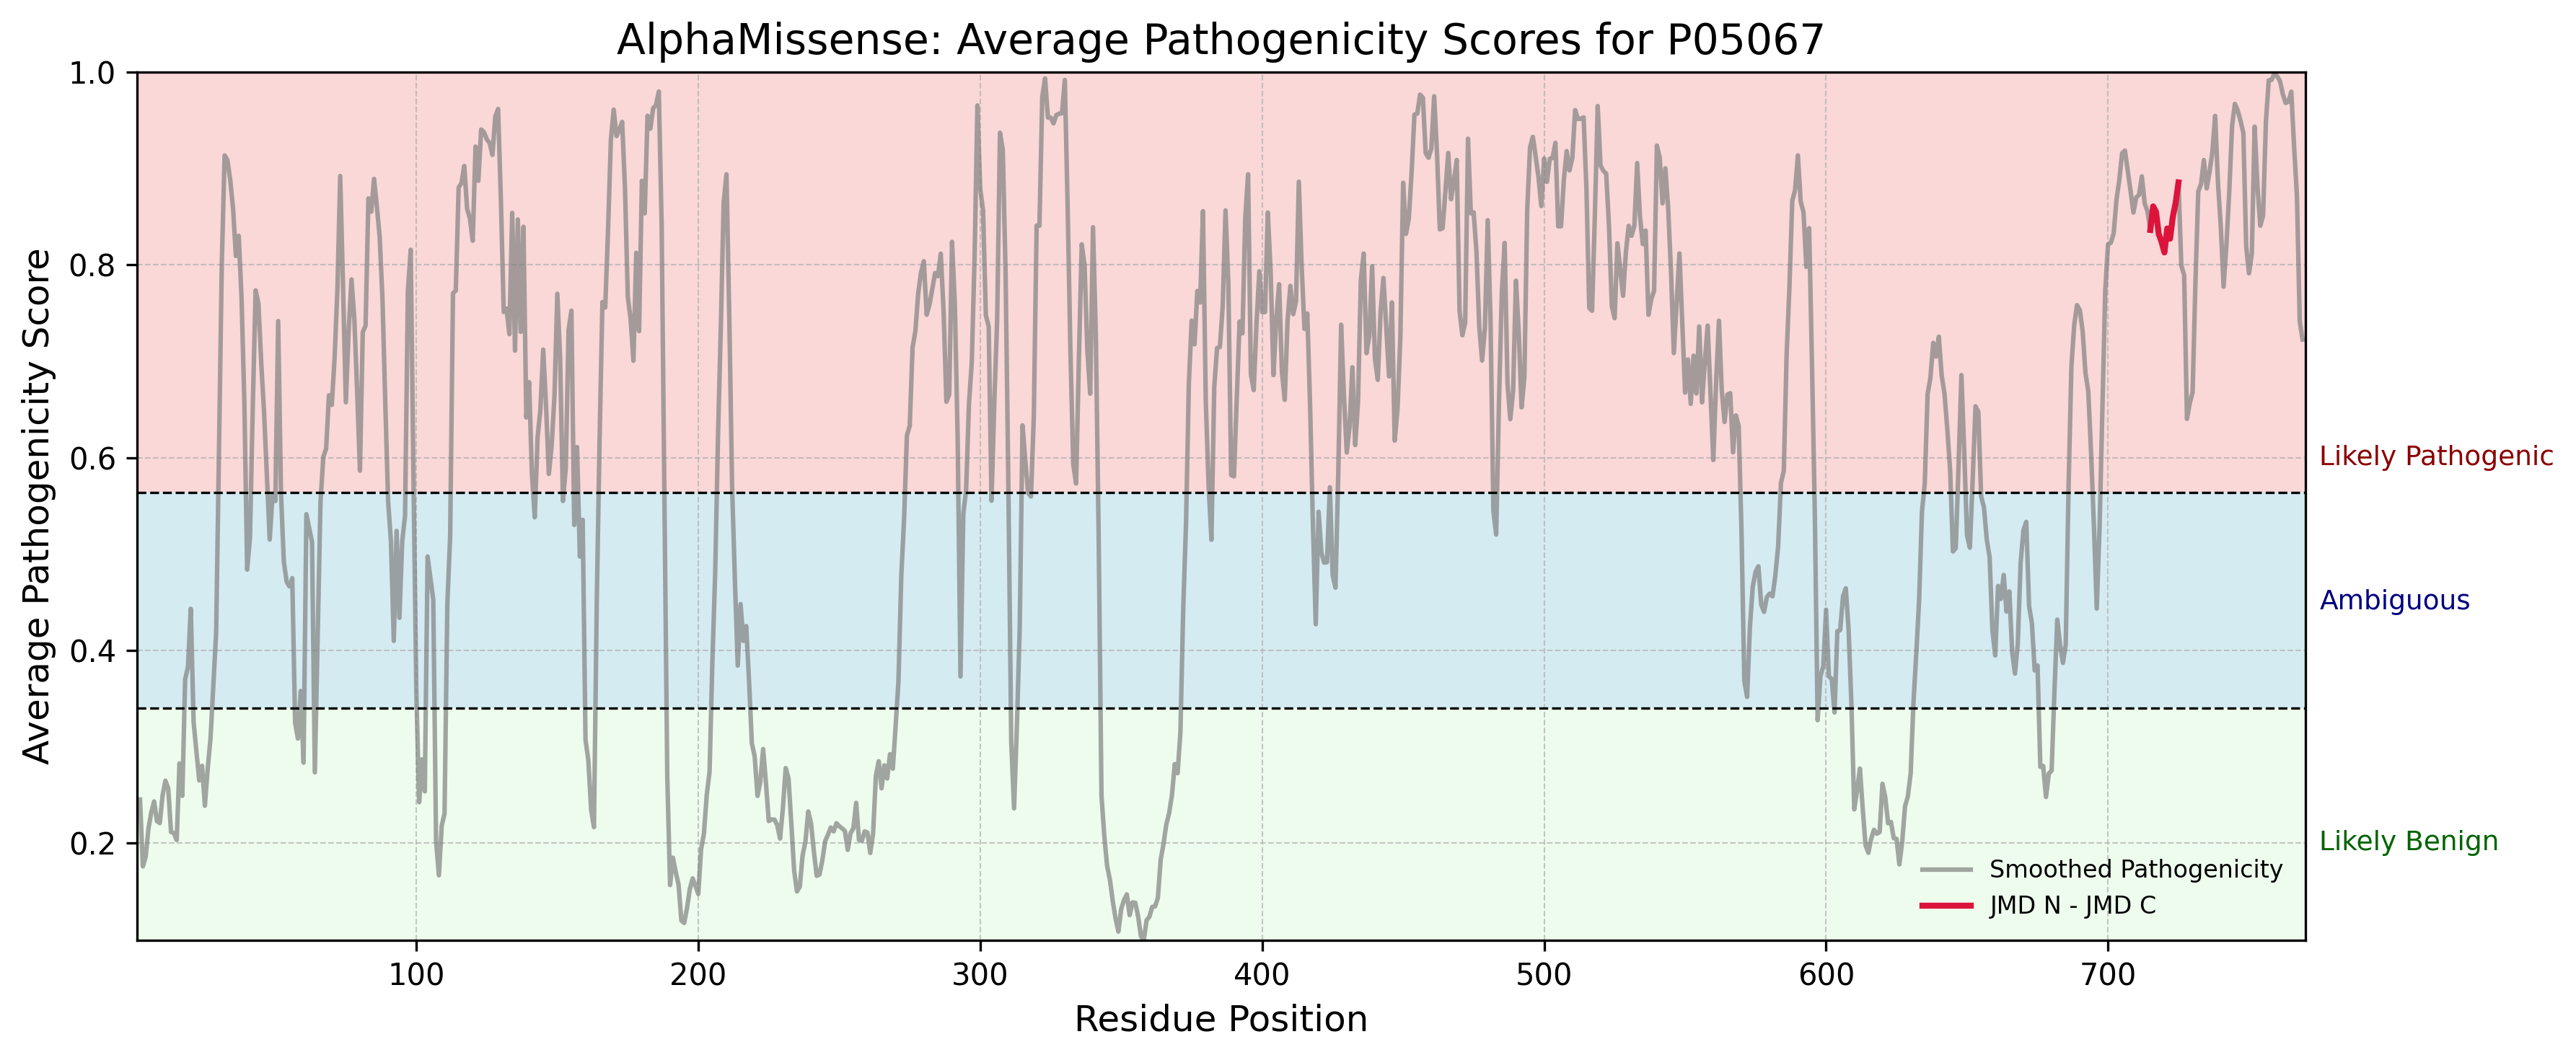

In [74]:
# Define Protein to be plotted
protein_id ='P05067'

mean_pathway = '/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/AlphaMissense_mean_csv'
highlight_start, highlight_end, highlight_mask, plot_protein, TMD_start, TMD_end = compute_highlight_cleavage_region(protein_id, mean_pathway, df_predicted_cleaned)
print(highlight_start, highlight_end)
# Style setup
mpl.rcParams.update({
    "font.size": 10,
    "font.family": "sans-serif",
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

plt.figure(figsize=(12, 5), dpi=300)

# Base line (gray)
plt.plot(
    plot_protein['residue_position'],
    plot_protein['smoothed_pathogenicity'],
    color='gray',
    alpha=0.7,
    linewidth=1.5,
    label='Smoothed Pathogenicity'
)

# Highlight: TMD ± JMD (Jungle Green)
highlight_segment = plot_protein[
    (plot_protein['residue_position'] >= highlight_start) &
    (plot_protein['residue_position'] <= highlight_end)
]
plt.plot(
    highlight_segment['residue_position'],
    highlight_segment['smoothed_pathogenicity'],
    color='crimson',  # Jungle Green = #29AB87
    linewidth=2,
    label='JMD N - JMD C'
)

# Inner TMD (Red)
#tmd_segment = plot_protein[
    #(plot_protein['residue_position'] >= TMD_start) &
    #(plot_protein['residue_position'] <= TMD_end)
#]
#plt.plot(
   # tmd_segment['residue_position'],
   # tmd_segment['smoothed_pathogenicity'],
   # color='crimson',
   # linewidth=2.5,
   # label='TMD'
#)

# Shaded background regions for pathogenicity categories
plt.axhspan(0.564, 1, facecolor='lightcoral', alpha=0.3)
plt.axhspan(0.34, 0.564, facecolor='lightblue', alpha=0.5)
plt.axhspan(0, 0.34, facecolor='lightgreen', alpha=0.15)


# Threshold background (optional, can remove if too busy)
plt.axhline(y=0.34, color='black', linestyle='--', linewidth=0.8)
plt.axhline(y=0.564, color='black', linestyle='--', linewidth=0.8)

# Annotations for categories
plt.text(plot_protein['residue_position'].max() + 5, 0.6, 'Likely Pathogenic', color='darkred', fontsize=9, va='center')
plt.text(plot_protein['residue_position'].max() + 5, 0.45, 'Ambiguous', color='navy', fontsize=9, va='center')
plt.text(plot_protein['residue_position'].max() + 5, 0.2, 'Likely Benign', color='darkgreen', fontsize=9, va='center')

# Axes and title
plt.xlabel('Residue Position')
plt.ylabel('Average Pathogenicity Score')
plt.title(f'AlphaMissense: Average Pathogenicity Scores for {protein_id}')


plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlim(plot_protein['residue_position'].min(), plot_protein['residue_position'].max())
plt.ylim(plot_protein['smoothed_pathogenicity'].min(), 1)

# Legend
plt.legend(loc='lower right', frameon=False)

plt.tight_layout()

# Define path and filename
output_dir = '/Users/doma/Documents/Bachelor Arbeit/1.Task_BA'
filename = f'{protein_id}_pathogenicity_plot_no_smoothing.png'
save_path = os.path.join(output_dir, filename)

# Save plot
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


### Now Create Average over JMD_TMD_JMD Region and store in df
- average_tmd_pathogenicity

In [83]:
# Compute average pathogenicity for the transmembrane region (TMD, JMD-N, JMD-C)
mean_pathway = '/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/AlphaMissense_mean_csv'
df_means = {}

for entry in df_predicted_cleaned['entry']:

    # Access the .csv file of corresponding protein
    mean_pathway_entry = os.path.join(mean_pathway, entry + '_avg.csv')
    entry_p = pd.read_csv(mean_pathway_entry)
    
    # Get the Transmembrane Region of the protein = highlight_mask
    highlight_start, highlight_end, highlight_mask, plot_protein, TMD_start, TMD_end = compute_highlight_regions(entry, mean_pathway, df_predicted_cleaned)
    
    # Extract the average pathogenicity in this highlighted region
    highlighted_data = entry_p.loc[highlight_mask, 'avg_pathogenicity']

    # Compute average pathogenicity in the transmembrane region
    df_means[entry] = highlighted_data.mean()


# Create a dataframe from the dictionary df_means
average_tmd_pathogenicity = pd.DataFrame.from_dict(df_means, orient='index',
                                                   columns=['avg_tmd_pathogenicity'])

# Reset index to make 'entry' a column, not index
average_tmd_pathogenicity = average_tmd_pathogenicity.reset_index()
average_tmd_pathogenicity = average_tmd_pathogenicity.rename(columns={'index': 'entry'})

# Merge with pred_class from df_predicted_cleaned
average_tmd_pathogenicity = average_tmd_pathogenicity.merge(
    df_predicted_cleaned[['entry', 'pred_class', 'PRED_MEAN [%]']],
    on='entry',
    how='left'
)

# Save the DataFrame as .csv file
#average_tmd_pathogenicity.to_csv('/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/Average_cleavage_region_11AA_Pathogenicity.csv', index=False)



In [84]:
average_tmd_pathogenicity.head(15)

,entry,avg_tmd_pathogenicity,pred_class,PRED_MEAN [%]
0,P16150,0.475119,HC substrate,95.22
1,P28827,0.680331,HC substrate,94.79
2,P10586,0.709868,HC substrate,94.64
3,Q06418,0.526596,HC substrate,94.49
4,P54764,0.621153,HC substrate,94.39
5,P19022,0.779756,HC substrate,94.37
6,O60469,0.493718,HC substrate,94.34
7,Q14118,0.820068,HC substrate,94.24
8,P09603,0.394054,HC substrate,94.07
9,P23468,0.799947,HC substrate,93.84


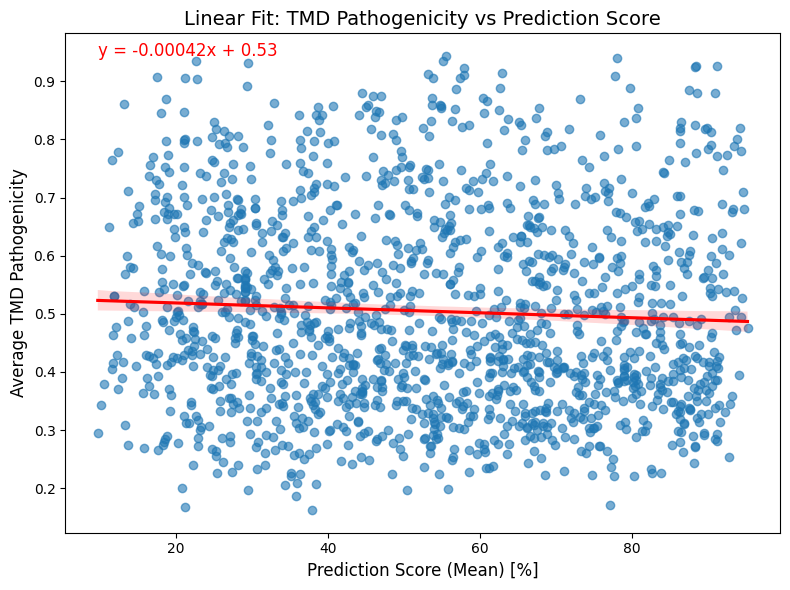

In [85]:
x1 = average_tmd_pathogenicity["PRED_MEAN [%]"]
y1 = average_tmd_pathogenicity["avg_tmd_pathogenicity"]

# Linear regression
slope, intercept = np.polyfit(x1, y1, 1)
regression_eq = f"y = {slope:.5f}x + {intercept:.2f}"

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(x=x1, y=y1, scatter_kws={'alpha':0.6}, line_kws={"color": "red"})
plt.xlabel("Prediction Score (Mean) [%]")
plt.ylabel("Average TMD Pathogenicity")
plt.title("Linear Fit: TMD Pathogenicity vs Prediction Score")
plt.text(x1.min(), y1.max(), regression_eq, fontsize=12, color="red")  # equation on plot
plt.tight_layout()
plt.show()

## Statistical Testing
- confidence groups are not normally distributed

In [311]:
# Check for normality with SHAPIRO test
from scipy.stats import shapiro

for name, group in average_tmd_pathogenicity.groupby('pred_class', observed=True):
    stat, p = shapiro(group['avg_tmd_pathogenicity'])
    print(f"{name}: p = {p:.3f} {'(normal)' if p > 0.05 else '(not normal)'}")

HC substrate: p = 0.000 (not normal)
LC substrate: p = 0.000 (not normal)
LC non-substrate: p = 0.000 (not normal)
HC non-substrate: p = 0.026 (not normal)


Shapiro-Wilk test for 'HC substrate': p = 0.0000 (not normal)
Shapiro-Wilk test for 'LC substrate': p = 0.0000 (not normal)
Shapiro-Wilk test for 'LC non-substrate': p = 0.0000 (not normal)
Shapiro-Wilk test for 'HC non-substrate': p = 0.0258 (not normal)


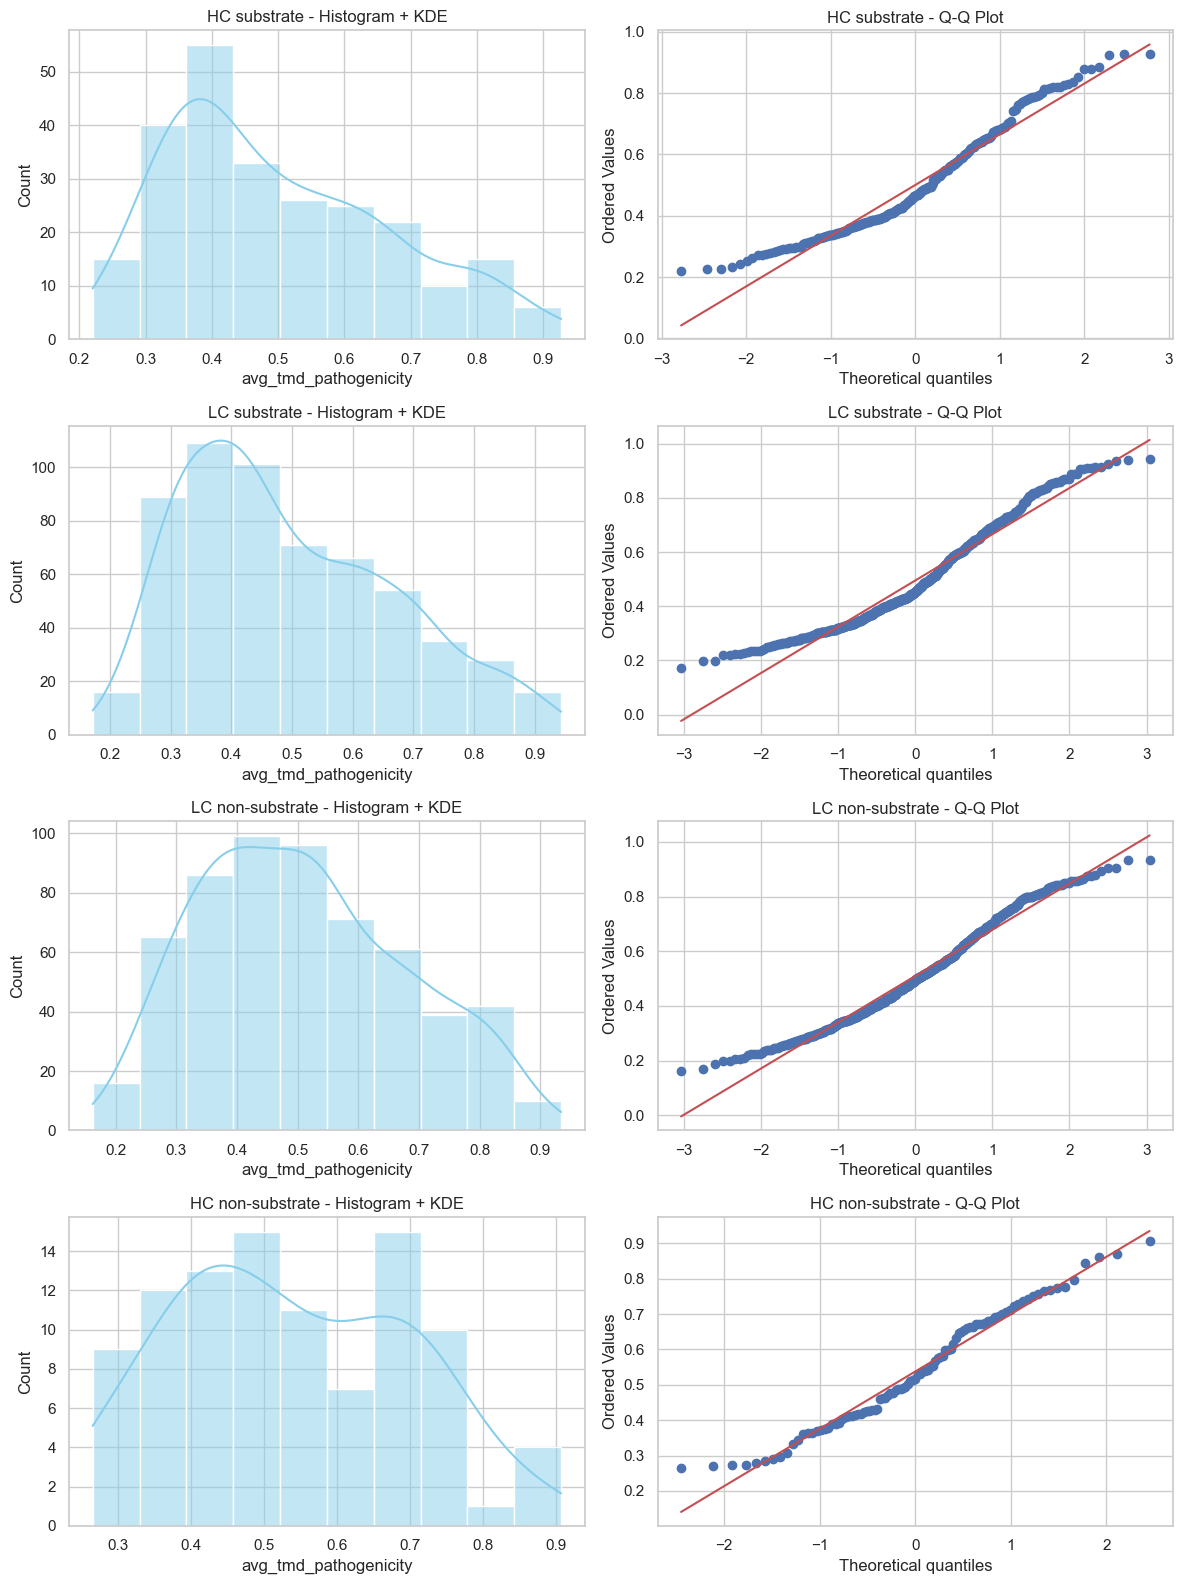

In [261]:
from scipy.stats import shapiro, probplot

# Set plot style
sns.set(style="whitegrid")

# Get all unique prediction classes
classes = average_tmd_pathogenicity['pred_class'].unique()

# Create subplots for histogram + KDE and Q-Q plots
fig, axes = plt.subplots(len(classes), 2, figsize=(12, 4 * len(classes)))

for i, pred_class in enumerate(classes):
    subset = average_tmd_pathogenicity[average_tmd_pathogenicity['pred_class'] == pred_class]['avg_tmd_pathogenicity']
    
    # Histogram + KDE
    sns.histplot(subset, kde=True, ax=axes[i, 0], bins=10, color='skyblue')
    axes[i, 0].set_title(f'{pred_class} - Histogram + KDE')
    axes[i, 0].set_xlabel('avg_tmd_pathogenicity')

    # Q-Q plot
    probplot(subset, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'{pred_class} - Q-Q Plot')

    # Shapiro-Wilk test
    stat, p = shapiro(subset)
    print(f"Shapiro-Wilk test for '{pred_class}': p = {p:.4f} {'(normal)' if p > 0.05 else '(not normal)'}")

plt.tight_layout()
plt.show()

In [313]:
# Check on variance homogenity
from scipy.stats import levene

# Prepare group-wise values
groups = [group['avg_tmd_pathogenicity'].values for name, group in average_tmd_pathogenicity.groupby('pred_class', observed=True)]

# Levene’s test
stat, p = levene(*groups)
print(f"Levene’s test: stat = {stat:.4f}, p = {p:.4f} {'→ equal variances' if p > 0.05 else '→ unequal variances'}")


Levene’s test: stat = 0.1937, p = 0.9007 → equal variances


In [ ]:
print(groups)

In [328]:
# Use non-parametric statistical test - used for comparing two or more independent samples of equal or different sample sizes.
# It extends the Mann–Whitney U test, which is used for comparing only two groups. 

from scipy import stats

# Prepare group-wise values
groups = [group['avg_tmd_pathogenicity'].values for name, group in average_tmd_pathogenicity.groupby('pred_class', observed=True)]

# Apply Kruskal-Wallis test
stat, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis H statistic: {stat:.3f}")
print(f"p-value: {p_value:.4f}")

Kruskal-Wallis H statistic: 8.473
p-value: 0.0372


In [329]:
import scikit_posthocs as sp

# Run Dunn’s test (non-parametric pairwise with correction)
posthoc = sp.posthoc_dunn(average_tmd_pathogenicity, val_col='avg_tmd_pathogenicity', group_col='pred_class', p_adjust='Bonferroni')

print(posthoc)


                  HC substrate  LC substrate  LC non-substrate  \
HC substrate          1.000000      1.000000          1.000000   
LC substrate          1.000000      1.000000          0.395627   
LC non-substrate      1.000000      0.395627          1.000000   
HC non-substrate      0.222307      0.054444          0.620497   

                  HC non-substrate  
HC substrate              0.222307  
LC substrate              0.054444  
LC non-substrate          0.620497  
HC non-substrate          1.000000  


In [330]:
# group averages 
group_averages = average_tmd_pathogenicity.groupby('pred_class', observed=True)['avg_tmd_pathogenicity'].mean()
print(group_averages)

pred_class
HC substrate        0.500498
LC substrate        0.495141
LC non-substrate    0.509617
HC non-substrate    0.537917
Name: avg_tmd_pathogenicity, dtype: float64


In [1]:
# Ensure correct category order
order = ['HC substrate', 'LC substrate', 'LC non-substrate', 'HC non-substrate']
average_tmd_pathogenicity['pred_class'] = pd.Categorical(
    average_tmd_pathogenicity['pred_class'], categories=order, ordered=True
)

# Load posthoc matrix if not already loaded
# posthoc = pd.read_csv('path_to_posthoc.csv', index_col=0)  # Example if loading from file

# Compute mean and std
stats_df = average_tmd_pathogenicity.groupby('pred_class', observed=True)['avg_tmd_pathogenicity'].agg(['mean', 'std'])

# Plot
sns.set(style="white", context="notebook", font_scale=1.2)
plt.figure(figsize=(14, 7))

sns.violinplot(
    x='pred_class', 
    y='avg_tmd_pathogenicity', 
    hue='pred_class', 
    data=average_tmd_pathogenicity, 
    inner=None, 
    order=order, 
    palette="muted", 
    linewidth=1.2,
    legend=False
)

sns.swarmplot(
    x='pred_class', 
    y='avg_tmd_pathogenicity', 
    data=average_tmd_pathogenicity, 
    color='black', 
    alpha=0.6,
    size=5, 
    order=order,
    edgecolor='0.5',
    linewidth=0.5
)

# Plot mean ± std
for i, cls in enumerate(order):
    mean = stats_df.loc[cls, 'mean']
    std = stats_df.loc[cls, 'std']
    plt.errorbar(i, mean, yerr=std, fmt='o', color='white', capsize=5, lw=2, zorder=4)
    plt.text(i + 0.05, mean, f"{mean:.4f}", ha='left', va='center',
         fontsize=16, color='white', weight='bold', zorder=5)

# Significance lines (based on your posthoc matrix)
def get_significance_symbol(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    return None

y_max = average_tmd_pathogenicity['avg_tmd_pathogenicity'].max()
line_height = y_max + 0.02
increment = 0.03
comparisons = [
    ('HC substrate', 'HC non-substrate'),
    ('HC substrate', 'LC substrate'),
    ('HC substrate', 'LC non-substrate'),
    ('LC substrate', 'HC non-substrate'),
    ('LC non-substrate', 'HC non-substrate'),
    ('LC substrate', 'LC non-substrate')
]

for i, (group1, group2) in enumerate(comparisons):
    p_val = posthoc.loc[group1, group2] if group1 in posthoc.index and group2 in posthoc.columns else posthoc.loc[group2, group1]
    symbol = get_significance_symbol(p_val)
    if symbol:
        x1, x2 = order.index(group1), order.index(group2)
        y = line_height + i * increment
        plt.plot([x1, x1, x2, x2], [y, y + 0.01, y + 0.01, y], lw=1.5, color='k')
        plt.text((x1 + x2) / 2, y + 0.015, symbol, ha='center', va='bottom', color='k', fontsize=14)

# Final plot styling
plt.title('Average Pathogenicity of TMD Regions per Prediction Class', fontsize=18, weight='bold')
plt.xlabel('', fontsize=14)
plt.ylabel('Average TMD Pathogenicity', fontsize=14)
plt.xticks(rotation=0, fontsize=13, weight='bold')
plt.yticks(fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()


plt.savefig('/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/AlphaMissense_violinplot_pred_classes.png', dpi=300, bbox_inches='tight')  # You can change the filename/format

plt.show()


NameError: name 'pd' is not defined

In [338]:
# Check on variance homogenity and normal distribution of the two merged groups

# Subset the groups
group1 = average_tmd_pathogenicity[average_tmd_pathogenicity['merged_class'] == 'Substrate']['avg_tmd_pathogenicity']
group2 = average_tmd_pathogenicity[average_tmd_pathogenicity['merged_class'] == 'Non-substrate']['avg_tmd_pathogenicity']

# Normality check (Shapiro-Wilk test)
shapiro_g1 = shapiro(group1)
shapiro_g2 = shapiro(group2)

print(f"Shapiro-Wilk test (Substrate): p-value = {shapiro_g1.pvalue:.4f} <0.05 = not normal")
print(f"Shapiro-Wilk test (Non-substrate): p-value = {shapiro_g2.pvalue:.4f} <0.05 = not normal")

# Variance homogeneity check (Levene's test)
levene_test = levene(group1, group2)
print(f"Levene's test for equal variances: p-value = {levene_test.pvalue:.4f} >0.05 = equal variances")


Shapiro-Wilk test (Substrate): p-value = 0.0000 <0.05 = not normal
Shapiro-Wilk test (Non-substrate): p-value = 0.0000 <0.05 = not normal
Levene's test for equal variances: p-value = 0.7458 >0.05 = equal variances


Mann Whitney U test's p-value is: 0.018030521468977382


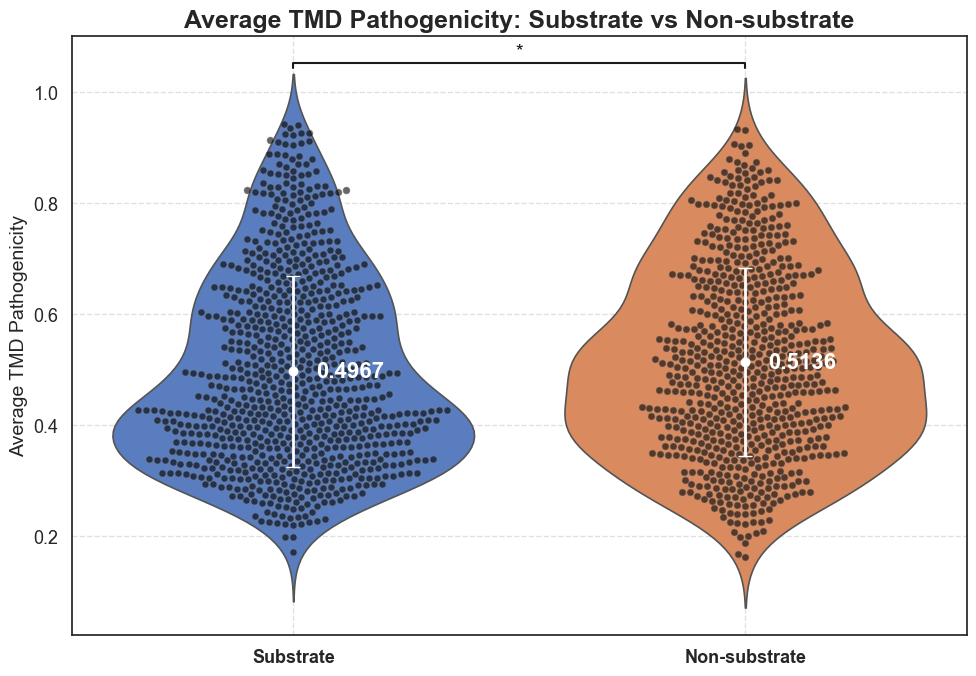

In [339]:
# Plot the the merged groups
# Use Mann-Whitney U Test because non-normal distribution

# Create a new column with merged categories
merge_map = {
    'HC substrate': 'Substrate',
    'LC substrate': 'Substrate',
    'LC non-substrate': 'Non-substrate',
    'HC non-substrate': 'Non-substrate'
}
average_tmd_pathogenicity['merged_class'] = average_tmd_pathogenicity['pred_class'].map(merge_map)

# Set new order
merged_order = ['Substrate', 'Non-substrate']
average_tmd_pathogenicity['merged_class'] = pd.Categorical(
    average_tmd_pathogenicity['merged_class'], categories=merged_order, ordered=True
)

# Compute mean and std for merged groups
stats_df = average_tmd_pathogenicity.groupby('merged_class', observed=True)['avg_tmd_pathogenicity'].agg(['mean', 'std'])

# Plot
sns.set(style="white", context="notebook", font_scale=1.2)
plt.figure(figsize=(10, 7))

sns.violinplot(
    x='merged_class',
    y='avg_tmd_pathogenicity',
    hue='merged_class',
    data=average_tmd_pathogenicity,
    inner=None,
    order=merged_order,
    palette="muted",
    linewidth=1.2,
    legend=False
)

sns.swarmplot(
    x='merged_class',
    y='avg_tmd_pathogenicity',
    data=average_tmd_pathogenicity,
    color='black',
    alpha=0.6,
    size=5,
    order=merged_order,
    edgecolor='0.5',
    linewidth=0.5
)

# Plot mean ± std and label
for i, cls in enumerate(merged_order):
    mean = stats_df.loc[cls, 'mean']
    std = stats_df.loc[cls, 'std']
    plt.errorbar(i, mean, yerr=std, fmt='o', color='white', capsize=5, lw=2, zorder=4)
    plt.text(i + 0.05, mean, f"{mean:.4f}", ha='left', va='center',
             fontsize=16, color='white', weight='bold', zorder=5)

# Statistical test between Substrate vs Non-substrate
from scipy.stats import mannwhitneyu

group1 = average_tmd_pathogenicity[average_tmd_pathogenicity['merged_class'] == 'Substrate']['avg_tmd_pathogenicity']
group2 = average_tmd_pathogenicity[average_tmd_pathogenicity['merged_class'] == 'Non-substrate']['avg_tmd_pathogenicity']
stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')

print(f"Mann Whitney U test's p-value is: {p_val}")

# Significance annotation
def get_significance_symbol(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    return 'n.s.'

symbol = get_significance_symbol(p_val)
y_max = average_tmd_pathogenicity['avg_tmd_pathogenicity'].max()
y = y_max + 0.1

x1, x2 = 0, 1
plt.plot([x1, x1, x2, x2], [y, y + 0.01, y + 0.01, y], lw=1.5, color='k')
plt.text((x1 + x2) / 2, y + 0.015, symbol, ha='center', va='bottom', color='k', fontsize=14)

# Final styling
plt.title('Average TMD Pathogenicity: Substrate vs Non-substrate', fontsize=18, weight='bold')
plt.xlabel('', fontsize=14)
plt.ylabel('Average TMD Pathogenicity', fontsize=14)
plt.xticks(rotation=0, fontsize=13, weight='bold')
plt.yticks(fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('/Users/doma/Documents/Bachelor Arbeit/1.Task_BA/AlphaMissense_Substrate_vs_NONSubstrate.png', dpi=300, bbox_inches='tight')  # You can change the filename/format
plt.show()


Shapiro-Wilk test (Substrate): p-value = 0.0000 <0.05 = not normal
Shapiro-Wilk test (Non-substrate): p-value = 0.0000 <0.05 = not normal
Levene's test for equal variances: p-value = 0.7458 >0.05 = equal variances
